Hardware Accelerator Active: /physical_device:GPU:0
Dataset Loaded Successfully via TFDS.
Training samples: 60000
Image Shape: (28, 28, 1)
Starting Training on Calligraphy Data...
Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - kl_loss: 0.2641 - loss: 383.0257 - reconstruction_loss: 381.9694
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.3995 - loss: 328.6773 - reconstruction_loss: 323.0794
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.5446 - loss: 321.7322 - reconstruction_loss: 315.5538
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 1.7393 - loss: 317.5687 - reconstruction_loss: 310.6115
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.8999 - loss: 316.2589 - reconstruction_loss: 308.6591
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.9961 - loss: 315.4565 - reconstruction_loss: 307.4721
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 2.0393 - loss: 314.6516 - reconstruction_

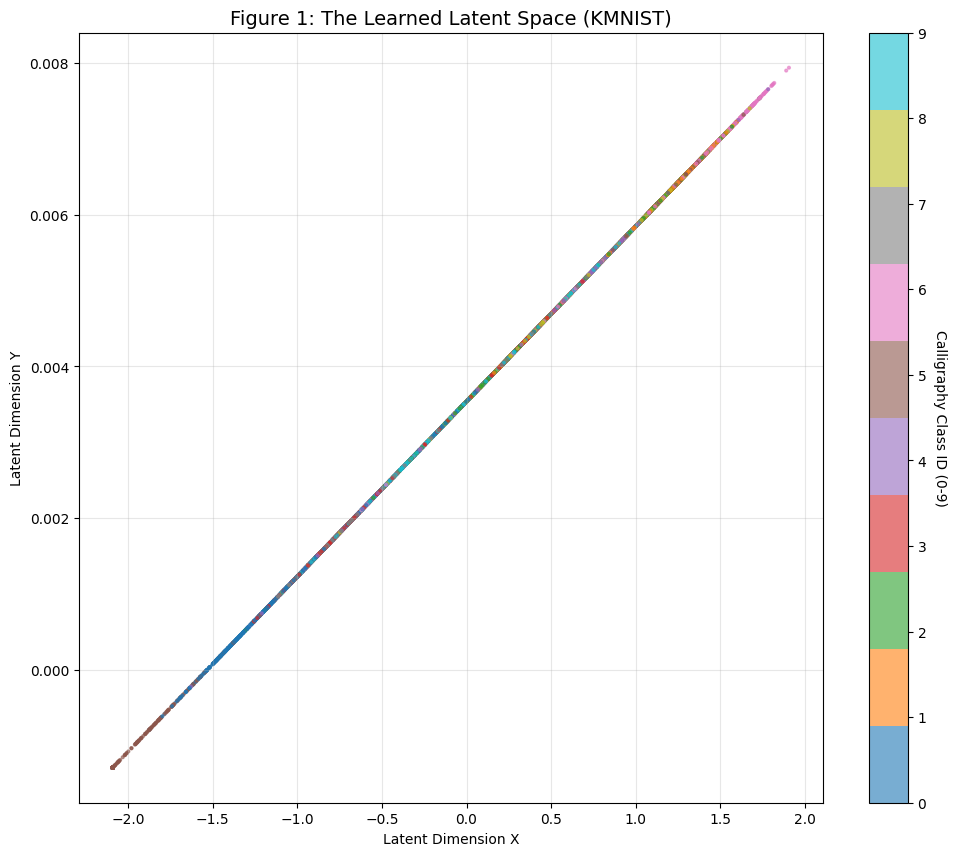

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


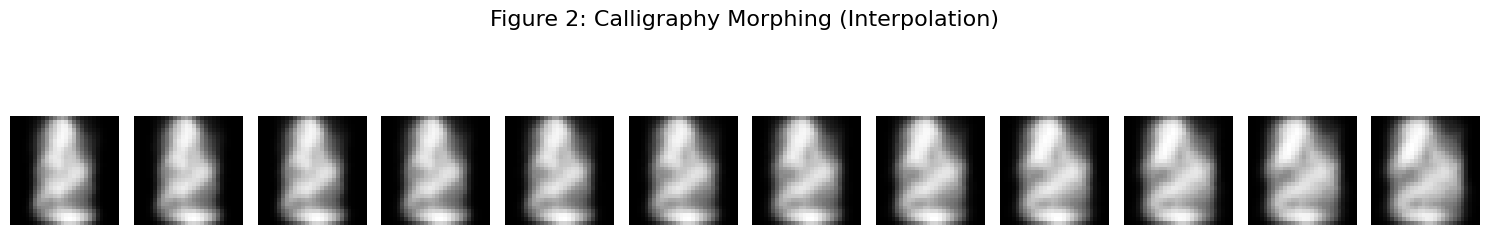

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds  #  The robust data loader
import matplotlib.pyplot as plt

# SECTION 1: SYSTEM CHECKS & DATA LOADING
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Hardware Accelerator Active: {gpus[0].name}")
else:
    print("WARNING: CPU mode detected. Enable GPU in Runtime settings for faster training.")

# Load KMNIST (Japanese Calligraphy) using TensorFlow Datasets
print("Downloading KMNIST via TensorFlow Datasets...")
try:
    # Load the full dataset into memory (batch_size=-1) as Numpy arrays
    train_data = tfds.load('kmnist', split='train', batch_size=-1, as_supervised=True)
    test_data = tfds.load('kmnist', split='test', batch_size=-1, as_supervised=True)

    # Convert from TFDS format to standard Numpy arrays
    train_images, train_labels = tfds.as_numpy(train_data)
    test_images, test_labels = tfds.as_numpy(test_data)

    print(f"Dataset Loaded Successfully via TFDS.")

except Exception as e:
    print(f"Error loading TFDS: {e}")

# Preprocessing: Normalize pixel values to be between 0 and 1
# Note: TFDS already provides images in (28, 28, 1) shape, so we don't need np.expand_dims
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

print(f"Training samples: {train_images.shape[0]}")
print(f"Image Shape: {train_images.shape[1:]}")

# SECTION 2: THE MODEL ARCHITECTURE

LATENT_DIMENSIONS = 2  # We compress images into a 2D map for easy visualization

class LatentSampler(layers.Layer):
    """
    The 'Reparameterization Trick'.
    Instead of sampling from a fixed point, we sample from a distribution defined
    by the mean and log-variance. This allows gradients to flow backwards.
    """
    def call(self, inputs):
        mean, log_variance = inputs
        batch_size = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, dim))
        # Formula: z = mean + sigma * epsilon
        return mean + tf.exp(0.5 * log_variance) * epsilon

# The Encoder
# Compresses the input image into the latent space
encoder_input = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Split into two vectors: Mean and Log-Variance
z_mean = layers.Dense(LATENT_DIMENSIONS, name="latent_mean")(x)
z_log_var = layers.Dense(LATENT_DIMENSIONS, name="latent_log_var")(x)
z_sample = LatentSampler()([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z_sample], name="encoder")

# The Decoder
# Reconstructs the image from the latent space
latent_input = keras.Input(shape=(LATENT_DIMENSIONS,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# Sigmoid activation ensures output pixels are between 0 and 1
decoder_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")

# SECTION 3: THE DISENTANGLED VAE (CUSTOM LOGIC)

class DisentangledVAE(keras.Model):
    """
    A Variational Autoencoder that allows for weighting of the KL-Divergence term.
    Increasing 'kl_weight' (Beta) > 1 forces better feature separation.
    """
    def __init__(self, encoder, decoder, kl_weight=1.0, **kwargs):
        super(DisentangledVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight # This is the Beta parameter
        # Trackers for monitoring performance
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # 1. Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 2. Calculate Reconstruction Loss (Pixel matching)
            # Sum over axes 1 and 2 (height and width)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # 3. Calculate KL Divergence (Regularization)
            # Measures how much our latent distribution deviates from a standard Normal dist.
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # 4. Total Loss (The Beta-VAE Equation)
            total_loss = recon_loss + (self.kl_weight * kl_loss)

        # 5. Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# SECTION 4: TRAINING

# We set kl_weight (Beta) to 4.0.
# This is an aggressive value that forces the model to disentangle features.
# A standard VAE would use 1.0.
vae_model = DisentangledVAE(encoder, decoder, kl_weight=4.0)

print("Starting Training on Calligraphy Data...")
vae_model.compile(optimizer=keras.optimizers.Adam())
vae_model.fit(train_images, epochs=25, batch_size=128)

# SECTION 5: VISUALIZATION (THE RESULTS)

def visualize_latent_clusters(model, data, labels):
    """Generates a scatter plot of the latent space."""
    z_mean, _, _ = model.encoder.predict(data, batch_size=128)
    plt.figure(figsize=(12, 10))
    # Using 'tab10' colormap for high contrast distinction between classes
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', alpha=0.6, s=4)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Calligraphy Class ID (0-9)", rotation=270, labelpad=15)
    plt.title("Figure 1: The Learned Latent Space (KMNIST)", fontsize=14)
    plt.xlabel("Latent Dimension X")
    plt.ylabel("Latent Dimension Y")
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_morphing(model, data, labels):
    """Demonstrates latent arithmetic by morphing between two classes."""
    # We will morph from Class 1 (Character 'Ki') to Class 8 (Character 'Re')
    # If using KMNIST, the classes are indices 0-9 representing specific Japanese hiragana.
    z_mean, _, _ = model.encoder.predict(data, batch_size=128)

    # Calculate the 'average' representation of these items
    # Note: KMNIST labels are integers 0-9.
    vector_a = np.mean(z_mean[labels == 1], axis=0)
    vector_b = np.mean(z_mean[labels == 8], axis=0)

    steps = 12
    fig, axes = plt.subplots(1, steps, figsize=(15, 3))
    plt.suptitle("Figure 2: Calligraphy Morphing (Interpolation)", fontsize=16)

    for i, alpha in enumerate(np.linspace(0, 1, steps)):
        # Linear Interpolation formula: (1-a)*A + a*B
        interpolated_vector = (1 - alpha) * vector_a + alpha * vector_b

        # Decode the hypothetical vector
        decoded_img = model.decoder.predict(interpolated_vector.reshape(1, 2), verbose=0)

        # Plot
        axes[i].imshow(decoded_img[0].reshape(28, 28), cmap='Greys_r')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Execute Visualizations
print("Generating Report Figures...")
visualize_latent_clusters(vae_model, test_images, test_labels)
visualize_morphing(vae_model, test_images, test_labels)